In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# %matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import inf

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [4]:
img_height = 32
img_width = 32

In [5]:
import torchvision
from torchvision import transforms, datasets

In [6]:
transform = transforms.Compose([transforms.Resize((img_height, img_width)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [7]:
train_path = './archive/train/'
train_path_real = './archive/train/REAL/'
test_path = './archive/test/'
test_path_real = './archive/test/REAL/'

In [8]:
train_dataset = datasets.ImageFolder(root = train_path, transform=transform)
test_dataset = datasets.ImageFolder(root = test_path, transform=transform)

In [9]:
from torch.utils.data import DataLoader

In [10]:
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=True)    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


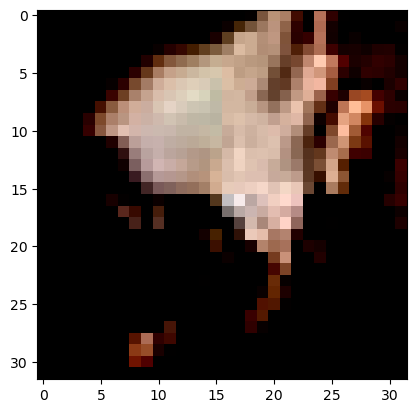

Label: 0


In [11]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img.transpose_(0, 2)
#display the image
plt.imshow(img, cmap="gray")
label = train_labels[1]
#plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [12]:
#split the datasets
from sklearn.model_selection import train_test_split

X_set, X_test, y_set, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_set, y_set, test_size=0.2, random_state=42)



In [13]:
#create a model

class Discriminator(nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels = 32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels = 32, kernel_size=5)
        #self.conv = nn.Conv2d(in_channels=3, out_channels = 32, kernel_size=(3,3))

        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 32 * 5 * 5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x.squeeze()

In [14]:
discriminator = Discriminator().to(device)


In [15]:
print(X_train.shape, X_val.shape, X_test.shape)

torch.Size([40, 3, 32, 32]) torch.Size([11, 3, 32, 32]) torch.Size([13, 3, 32, 32])


In [16]:
#convert tensors to floats
X_train = X_train.float()
X_val = X_val.float()
X_test = X_test.float()
y_train = y_train.float()
y_val = y_val.float()
y_test = y_test.float()

In [17]:
model = Discriminator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
accuracy_list = []

def train(epochs, model, perm=torch.arange(0, 784).long()):
    model.train()
    for epoch in range(epochs):
      for batch_idx, (data, target) in enumerate(trainloader):
          # send to device
          data, target = data.to(device), target.to(device)
          
          data = data.float()
          target = target.float()

          optimizer.zero_grad()
          output = model(data)
          loss = F.binary_cross_entropy(output, target)
          loss.backward()
          optimizer.step()
          if batch_idx % 100 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(trainloader.dataset),
                  100. * batch_idx / len(trainloader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        data = data.float()
        target = target.float()
        # permute pixels
        output = model(data)
        test_loss += F.binary_cross_entropy(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = (output > 0.5).float()                                                                
        correct += (pred == target).cpu().sum().item()


    test_loss /= len(testloader.dataset)
    accuracy = 100. * correct / len(testloader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        accuracy))
     


In [19]:
train(5, model)

Train Epoch: 0 [0/100000 (0%)]	Loss: 0.694915
Train Epoch: 0 [6400/100000 (6%)]	Loss: 0.703660
Train Epoch: 0 [12800/100000 (13%)]	Loss: 0.392724
Train Epoch: 0 [19200/100000 (19%)]	Loss: 0.324968
Train Epoch: 0 [25600/100000 (26%)]	Loss: 0.253654
Train Epoch: 0 [32000/100000 (32%)]	Loss: 0.432847
Train Epoch: 0 [38400/100000 (38%)]	Loss: 0.170112
Train Epoch: 0 [44800/100000 (45%)]	Loss: 0.256195
Train Epoch: 0 [51200/100000 (51%)]	Loss: 0.318071
Train Epoch: 0 [57600/100000 (58%)]	Loss: 0.123973
Train Epoch: 0 [64000/100000 (64%)]	Loss: 0.210147
Train Epoch: 0 [70400/100000 (70%)]	Loss: 0.185180
Train Epoch: 0 [76800/100000 (77%)]	Loss: 0.245551
Train Epoch: 0 [83200/100000 (83%)]	Loss: 0.253817
Train Epoch: 0 [89600/100000 (90%)]	Loss: 0.315371
Train Epoch: 0 [96000/100000 (96%)]	Loss: 0.288296
Train Epoch: 1 [0/100000 (0%)]	Loss: 0.260165
Train Epoch: 1 [6400/100000 (6%)]	Loss: 0.289908
Train Epoch: 1 [12800/100000 (13%)]	Loss: 0.234039
Train Epoch: 1 [19200/100000 (19%)]	Loss: 0.2

In [20]:
test(model)


Test set: Average loss: 0.1514, Accuracy: 18794/20000 (94%)



In [21]:
model_scripted = torch.jit.script(model)
torch.jit.save(model_scripted, "model.pt")